# Imports

In [ ]:
from IPython.display import clear_output
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

std_norm = sp.stats.norm(0, 1)

In [2]:
import sys, os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from main.matrix_inverters import Gower_Richtarik_2016_4 as algo4_original
from main.matrix_inverters import Gower_Richtarik_2016_4_corrected as algo4_corrected
from main.matrix_inverters import inv_sqrt

# SPD Inversion (scipy vs. original/correcteed algo)

In [ ]:
Ns = np.arange(4, 101, 1)

scipy_times = []
scipy_errors = []

algo4_original_times = []
algo4_original_errors = []

algo4_corrected_times = []
algo4_corrected_errors = []

for n in Ns:
    I = np.eye(n)
    A = std_norm.rvs(size=(n, n))
    A = A.T @ A + 0.001 * np.eye(n)
    
    start = time.time()
    A_inv = sp.linalg.inv(A)
    end = time.time()
    scipy_times.append(end - start)
    scipy_errors.append(np.linalg.matrix_norm(A @ A_inv - I))

    start = time.time()
    A_inv = algo4_original(A, max_iters=300)
    end = time.time()
    algo4_original_times.append(end - start)
    algo4_original_errors.append(np.linalg.matrix_norm(A @ A_inv - I))

    start = time.time()
    A_inv = algo4_corrected(A, max_iters=300)
    end = time.time()
    algo4_corrected_times.append(end - start)
    algo4_corrected_errors.append(np.linalg.matrix_norm(A @ A_inv - I))

    clear_output()

scipy_errors = np.array(scipy_errors)
algo4_original_errors = np.array(algo4_original_errors)
algo4_corrected_errors = np.array(algo4_corrected_errors)

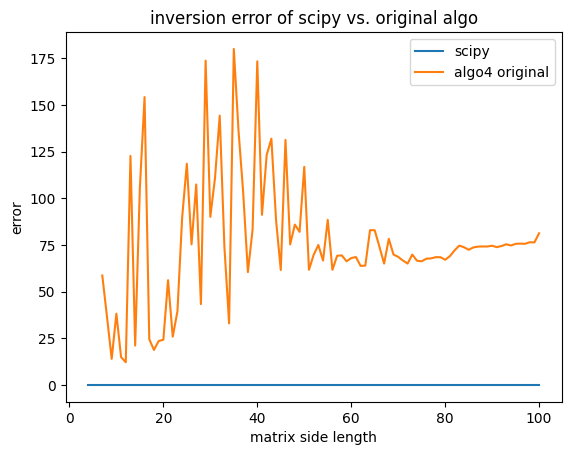

In [12]:
plt.plot(Ns, scipy_errors, label='scipy')
plt.plot(Ns, algo4_original_errors, label='algo4 original')
plt.xlabel('matrix side length')
plt.ylabel('error')
plt.title('inversion error of scipy vs. original algo')
plt.legend()
plt.show()

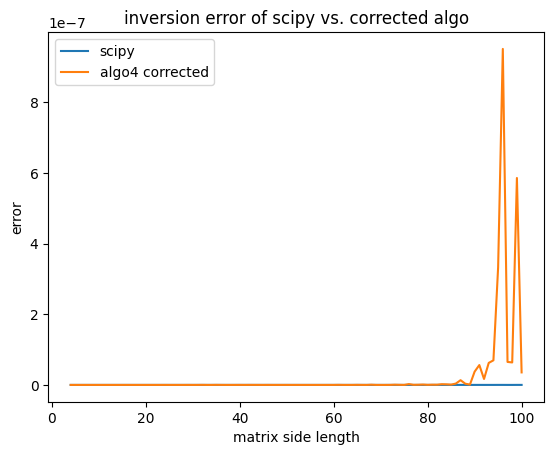

In [34]:
plt.plot(Ns, scipy_errors, label='scipy')
plt.plot(Ns, algo4_corrected_errors, label='algo4 corrected')
plt.xlabel('matrix side length')
plt.ylabel('error')
plt.title('inversion error of scipy vs. corrected algo')
plt.legend()
plt.show()

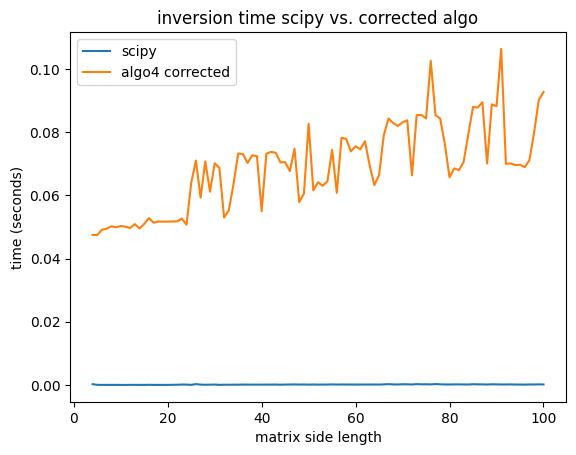

In [10]:
plt.plot(Ns, scipy_times, label='scipy')
plt.plot(Ns, algo4_corrected_times, label='algo4 corrected')
plt.xlabel('matrix side length')
plt.ylabel('time (seconds)')
plt.title('inversion time scipy vs. corrected algo')
plt.legend()
plt.show()

# Convergence

In [167]:
def algo4_corrected_logging(A: np.ndarray, max_iters=10000, tol=1e-10, sketch_frac=None, precondition=True) -> np.ndarray:
    assert np.allclose(A, A.T), 'Please ensure input matrix is symmetric.'

    n = A.shape[0]
    m = int(n ** 0.5) if sketch_frac == None else int(n * sketch_frac)
    
    #tol *= n

    I = np.eye(n)

    if precondition:
        # scale identity by trace(A) / trace(A^2)
        L = sp.linalg.cholesky(I * np.trace(A) / np.trace(A @ A), lower=True)
    else:
        L = np.eye(n)

    errors = []
    for num_iter in range(max_iters):
        errors.append(np.linalg.matrix_norm(L @ L.T @ A - I))
        if errors[-1] < tol:
            break

        S_tilde = std_norm.rvs(size=(n, m))
        S = L @ S_tilde
        R = inv_sqrt(S.T @ A @ S)
        L += S @ R @ (inv_sqrt(S_tilde.T @ S_tilde) @ S_tilde.T - R.T @ S.T @ A @ L)
        
    return L @ L.T, errors

In [186]:
n = 200

I = np.eye(n)
A = std_norm.rvs(size=(n, n))
A = A.T @ A + 0.01 * np.eye(n)

In [187]:
_, errors = algo4_corrected_logging(A)
errors = np.array(errors)

Text(0.5, 1.0, 'inverting 200x200 matrix, final error 9.48e-11')

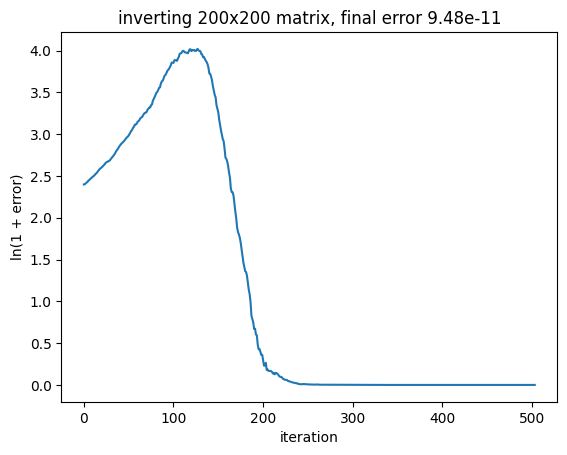

In [188]:
plt.plot(np.log(1 + errors))
plt.xlabel('iteration')
plt.ylabel('ln(1 + error)')
plt.title(f'inverting {n}x{n} matrix, final error{errors[-1]: .2e}')

# Mini benchmarks

This section is a sandbox to test various choices for my implementation of the algorithm.

## matrix vs. ndarray

ndarray is faster

In [ ]:
n = 1000

A_matrix = np.matrix(std_norm.rvs(size=(n, n)))
B_matrix = np.matrix(std_norm.rvs(size=(n, n)))

A_ndarray = std_norm.rvs(size=(n, n))
B_ndarray = std_norm.rvs(size=(n, n))

In [ ]:
%%timeit
A_matrix * B_matrix

4.93 ms ± 52.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
A_ndarray @ B_ndarray

4.68 ms ± 23.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## inv_cho vs. cho_inv

inv_cho and cho_inv are not equivalent.

$A = L L^T \implies A^{-1} = (L L^T)^{-1} = L^{-T} L^{-1}$

In [ ]:
n = 4

A = std_norm.rvs(size=(n, n))
A = A @ A.T + 0.01 * np.eye(n, n)

np.allclose(
    sp.linalg.inv(sp.linalg.cholesky(A, lower=True)), 
    sp.linalg.cholesky(sp.linalg.inv(A), lower=True)
)

False

## Using cho/inv in algo4

In [15]:
def cho_inv(M: np.ndarray) -> np.ndarray:
    return sp.linalg.cholesky(np.linalg.inv(M), lower=True)

def inv_cho(M: np.ndarray) -> np.ndarray:
    return sp.linalg.inv(sp.linalg.cholesky(M, lower=True))

def algo4_cho_inv(A: np.ndarray, max_iters=1000, tol=1e-2, tol_check_period=100, sketch_frac=None, precondition=True, config:dict={}) -> np.ndarray:
    assert np.allclose(A, A.T), 'Please ensure input matrix is symmetric.'

    n = A.shape[0]
    m = int(n ** 0.5) if sketch_frac == None else int(n * sketch_frac)
    
    tol *= n

    I = np.eye(n)

    if precondition:
        # scale identity by trace(A) / trace(A^2)
        L = sp.linalg.cholesky(I * np.trace(A) / np.trace(A @ A), lower=True)
    else:
        L = np.eye(n)

    for num_iter in range(max_iters):
        if tol_check_period and (num_iter % tol_check_period == 0):
            if np.linalg.matrix_norm(L @ L.T @ A - I) < tol:
                break

        S_tilde = std_norm.rvs(size=(n, m), random_state=num_iter)
        S = L @ S_tilde

        # cho/inv
        R = config[0](S.T @ A @ S)
        L += S @ R @ (config[1](S_tilde.T @ S_tilde) @ S_tilde.T - R.T @ S.T @ A @ L)
        
    if num_iter == max_iters - 1:
        print(f'Warning: Max. iterations ({max_iters}) reached without convergence.')
    
    return L @ L.T

def algo4_inv_sqrt(A: np.ndarray, max_iters=1000, tol=1e-2, tol_check_period=100, sketch_frac=None, precondition=True) -> np.ndarray:
    assert np.allclose(A, A.T), 'Please ensure input matrix is symmetric.'

    n = A.shape[0]
    m = int(n ** 0.5) if sketch_frac == None else int(n * sketch_frac)
    
    tol *= n

    I = np.eye(n)

    if precondition:
        # scale identity by trace(A) / trace(A^2)
        L = sp.linalg.cholesky(I * np.trace(A) / np.trace(A @ A), lower=True)
    else:
        L = np.eye(n)

    for num_iter in range(max_iters):
        if tol_check_period and (num_iter % tol_check_period == 0):
            if np.linalg.matrix_norm(L @ L.T @ A - I) < tol:
                break

        S_tilde = std_norm.rvs(size=(n, m), random_state=num_iter)
        S = L @ S_tilde

        R = inv_sqrt(S.T @ A @ S)
        L += S @ R @ (inv_sqrt(S_tilde.T @ S_tilde) @ S_tilde.T - R.T @ S.T @ A @ L)
    
    if num_iter == max_iters - 1:
        print(f'Warning: Max. iterations ({max_iters}) reached without convergence.')
    
    return L @ L.T

### Order

There are two places where inv_sqrt appears in algo4. This gives us 4 possibilities for using cho_inv or inv_cho in these places. Only (cho_inv, inv_cho) converges.

In [16]:
n = 20

A = std_norm.rvs(size=(n, n))
A = A.T @ A

In [17]:
print('inv_sqrt error:', np.linalg.matrix_norm((algo4_inv_sqrt(A) @ A) - np.eye(n)))
print('(cho_inv, cho_inv) error:', np.linalg.matrix_norm((algo4_cho_inv(A, config={
    0: cho_inv, 1: cho_inv
}) @ A) - np.eye(n)))
print('(cho_inv, inv_cho) error:', np.linalg.matrix_norm((algo4_cho_inv(A, config={
    0: cho_inv, 1: inv_cho
}) @ A) - np.eye(n)))

inv_sqrt error: 0.00043574699941422937
(cho_inv, cho_inv) error: 23.369776813687267
(cho_inv, inv_cho) error: 0.00015208295549276125


In [18]:
try:
    print('(inv_cho, cho_inv) error:', np.linalg.matrix_norm((algo4_cho_inv(A, config={
    0: inv_cho, 1: cho_inv
}) @ A) - np.eye(n)))
except Exception as e:
    print('inv_cho, cho_inv', e)

inv_cho, cho_inv 3-th leading minor of the array is not positive definite


In [19]:
try:
    print('(inv_cho, inv_cho) error:', np.linalg.matrix_norm((algo4_cho_inv(A, config={
    0: inv_cho, 1: inv_cho
}) @ A) - np.eye(n)))
except Exception as e:
    print('(inv_cho, inv_cho)', e)

(inv_cho, inv_cho) 3-th leading minor of the array is not positive definite


### Speed and accuracy of inv_sqrt vs. cho/solve

cho/solve is roughly 10% faster than inv_sqrt.

In [21]:
def algo4_cho_solve(A: np.ndarray, max_iters=1000, tol=1e-2, tol_check_period=100, sketch_frac=None, precondition=True) -> np.ndarray:
    """
    Algorithm 4 from Gower and Richtárik (2016).
    Called Adaptive Randomised BFGS (AdaRBFGS).
    Input matrix must be symmetric positive definite.
    Parameters: distribution D.
    """
    assert np.allclose(A, A.T), 'Please ensure input matrix is symmetric.'

    n = A.shape[0]
    m = int(n ** 0.5) if sketch_frac == None else int(n * sketch_frac)
    
    tol *= n

    I = np.eye(n)

    if precondition:
        # scale identity by trace(A) / trace(A^2)
        L = sp.linalg.cholesky(I * np.trace(A) / np.trace(A @ A), lower=True)
    else:
        L = np.eye(n)

    for num_iter in range(max_iters):
        if tol_check_period and (num_iter % tol_check_period == 0):
            if np.linalg.matrix_norm(L @ L.T @ A - I) < tol:
                break

        S_tilde = std_norm.rvs(size=(n, m), random_state=num_iter)
        S = L @ S_tilde

        # cho/inv
        R = cho_inv(S.T @ A @ S)
        L += S @ R @ (sp.linalg.solve(sp.linalg.cholesky(S_tilde.T @ S_tilde), S_tilde.T) - R.T @ S.T @ A @ L)
        
    if num_iter == max_iters - 1:
        print(f'Warning: Max. iterations ({max_iters}) reached without convergence.')
    
    return L @ L.T

In [22]:
n = 20

A = std_norm.rvs(size=(n, n))
A = A.T @ A

In [23]:
%%timeit
algo4_inv_sqrt(A)
clear_output()

18.4 ms ± 225 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
algo4_cho_solve(A)
clear_output()

170 ms ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
n = 20

errors1 = []
errors2 = []
for _ in range(100):
    A = std_norm.rvs(size=(n, n))
    A = A.T @ A + 0.001 * np.eye(n)
    errors1.append(np.linalg.matrix_norm((algo4_inv_sqrt(A) @ A) - np.eye(n)))
    errors2.append(np.linalg.matrix_norm((algo4_cho_solve(A) @ A) - np.eye(n)))
    clear_output()

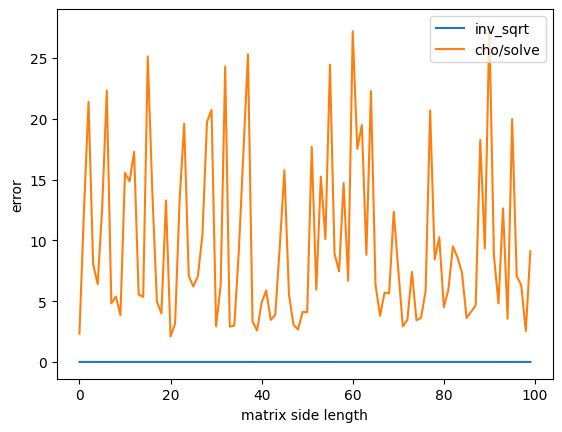

In [33]:
plt.plot(errors1, label='inv_sqrt')
plt.plot(errors2, label='cho/solve')
plt.xlabel('matrix side length')
plt.ylabel('error')
plt.legend()
plt.show()

## sqrt optimisation

The idea is to replace inv_sqrt(A) * B with solve(sqrt(A), B).

### Speed of custom sqrt vs. scipy sqrtm.

Custom sqrt is faster!

In [ ]:
def sqrt(A: np.ndarray) -> np.ndarray:
    eig, l = sp.linalg.eigh(A)
    eig = np.sqrt(eig)
    return l @ np.diag(eig) @ l.T

In [28]:
%%timeit
A = std_norm.rvs(size=(1000, 1000))
A = A.T @ A
_ = sqrt(A)

227 ms ± 6.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
A = std_norm.rvs(size=(1000, 1000))
A = A.T @ A
_ = sp.linalg.sqrtm(A)

479 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### inv_sqrt(A) * B vs. solve(sqrt(A), B)

inv_sqrt(A) * B seems around 10% faster.

In [ ]:
def inv_sqrt_mul(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    return inv_sqrt(A) @ B

def solve_sqrt(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    return sp.linalg.solve(sqrt(A), B)

In [31]:
%%timeit
A = std_norm.rvs(size=(1000, 1000))
A = A.T @ A
B = std_norm.rvs(size=(1000, 1000))
_ = inv_sqrt_mul(A, B)

256 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
A = std_norm.rvs(size=(1000, 1000))
A = A.T @ A
B = std_norm.rvs(size=(1000, 1000))
_ = solve_sqrt(A, B)

275 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
